# Recognize named entities on Twitter with LSTMs

In this assignment, you will use a recurrent neural network to solve Named Entity Recognition (NER) problem. NER is a common task in natural language processing systems. It serves for extraction such entities from the text as persons, organizations, locations, etc. In this task you will experiment to recognize named entities from Twitter.

For example, we want to extract persons' and organizations' names from the text. Than for the input text:

    Ian Goodfellow works for Google Brain

a NER model needs to provide the following sequence of tags:

    B-PER I-PER    O     O   B-ORG  I-ORG

Where *B-* and *I-* prefixes stand for the beginning and inside of the entity, while *O* stands for out of tag or no tag. Markup with the prefix scheme is called *BIO markup*. This markup is introduced for distinguishing of consequent entities with similar types.

A solution of the task will be based on neural networks, particularly, on Bi-Directional Long Short-Term Memory Networks (Bi-LSTMs).

### Libraries

For this task you will need the following libraries:
 - [Tensorflow](https://www.tensorflow.org) — an open-source software library for Machine Intelligence.
 
In this assignment, we use Tensorflow 1.15.0. You can install it with pip:

    !pip install tensorflow==1.15.0
     
 - [Numpy](http://www.numpy.org) — a package for scientific computing.
 
If you have never worked with Tensorflow, you would probably need to read some tutorials during your work on this assignment, e.g. [this one](https://www.tensorflow.org/tutorials/recurrent) could be a good starting point. 

### Data

The following cell will download all data required for this assignment into the folder `week2/data`.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    ! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.setup_week2()

import sys
sys.path.append("..")
from common.download_utils import download_week2_resources

download_week2_resources()

File data/train.txt is already downloaded.
File data/validation.txt is already downloaded.
File data/test.txt is already downloaded.


### Load the Twitter Named Entity Recognition corpus

We will work with a corpus, which contains tweets with NE tags. Every line of a file contains a pair of a token (word/punctuation symbol) and a tag, separated by a whitespace. Different tweets are separated by an empty line.

The function *read_data* reads a corpus from the *file_path* and returns two lists: one with tokens and one with the corresponding tags. You need to complete this function by adding a code, which will replace a user's nickname to `<USR>` token and any URL to `<URL>` token. You could think that a URL and a nickname are just strings which start with *http://* or *https://* in case of URLs and a *@* symbol for nicknames.

In [2]:
import re
URL_REGEX = "(https?|ftp|file):\/\/[\-A-Za-z0-9+&@#\/%?=~_|!:,.;]*[\-A-Za-z0-9+&@#\/%=~_|]"
USER_REGEX = '@([A-Za-z0-9_]+)'

In [3]:
def replace_urls(token):
    return re. sub(URL_REGEX, '<URL>', token)

def replace_username(token):
    return re.sub(USER_REGEX, '<USR>', token)

In [4]:
assert replace_urls('http://t.co/eQmogqqABK this is a tweet with url') == '<URL> this is a tweet with url'

In [5]:
assert replace_username('this is a tweet from a user @espoir_mur') == 'this is a tweet from a user <USR>'

In [6]:
def read_data(file_path):
    tokens = []
    tags = []
    
    tweet_tokens = []
    tweet_tags = []
    for line in open(file_path, encoding='utf-8'):
        line = line.strip()
        if not line:
            if tweet_tokens:
                tokens.append(tweet_tokens)
                tags.append(tweet_tags)
            tweet_tokens = []
            tweet_tags = []
        else:
            token, tag = line.split()
            token = replace_urls(token)
            token = replace_username(token)
            tweet_tokens.append(token)
            tweet_tags.append(tag)
    return tokens, tags

And now we can load three separate parts of the dataset:
 - *train* data for training the model;
 - *validation* data for evaluation and hyperparameters tuning;
 - *test* data for final evaluation of the model.

In [7]:
train_tokens, train_tags = read_data('data/train.txt')
validation_tokens, validation_tags = read_data('data/validation.txt')
test_tokens, test_tags = read_data('data/test.txt')

You should always understand what kind of data you deal with. For this purpose, you can print the data running the following cell:

In [8]:
for i in range(3):
    for token, tag in zip(train_tokens[i], train_tags[i]):
        print('%s\t%s' % (token, tag))
    print()

RT	O
<USR>	O
:	O
Online	O
ticket	O
sales	O
for	O
Ghostland	B-musicartist
Observatory	I-musicartist
extended	O
until	O
6	O
PM	O
EST	O
due	O
to	O
high	O
demand	O
.	O
Get	O
them	O
before	O
they	O
sell	O
out	O
...	O

Apple	B-product
MacBook	I-product
Pro	I-product
A1278	I-product
13.3	I-product
"	I-product
Laptop	I-product
-	I-product
MD101LL/A	I-product
(	O
June	O
,	O
2012	O
)	O
-	O
Full	O
read	O
by	O
eBay	B-company
<URL>	O
<URL>	O

Happy	O
Birthday	O
<USR>	O
!	O
May	O
Allah	B-person
s.w.t	O
bless	O
you	O
with	O
goodness	O
and	O
happiness	O
.	O



### Prepare dictionaries

To train a neural network, we will use two mappings: 
- {token}$\to${token id}: address the row in embeddings matrix for the current token;
- {tag}$\to${tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

Now you need to implement the function *build_dict* which will return {token or tag}$\to${index} and vice versa. 

In [9]:
from collections import defaultdict

In [10]:
def build_dict(tokens_or_tags, special_tokens):
    """
        tokens_or_tags: a list of lists of tokens or tags
        special_tokens: some special tokens
    """
    # Create a dictionary with default value 0
    token_to_index = defaultdict(lambda: 0)
    index_to_token = list()
    index_to_token_set = set()
    
    
    # Create mappings from tokens (or tags) to indices and vice versa.
    # At first, add special tokens (or tags) to the dictionaries.
    # The first special token must have index 0.
    
    # Mapping tok2idx should contain each token or tag only once. 
    # To do so, you should:
    # 1. extract unique tokens/tags from the tokens_or_tags variable, which is not
    #    occur in special_tokens (because they could have non-empty intersection)
    # 2. index them (for example, you can add them into the list idx2tok
    # 3. for each token/tag save the index into tok2idx).
    
    for index, special_token in enumerate(special_tokens):
        index_to_token_set.add(special_token)
        index_to_token.append(special_token)
        
    for sentence_index, token_or_tag in enumerate(tokens_or_tags):
        for word_index, word_or_tag in enumerate(token_or_tag, start=len(special_tokens)):
            if word_or_tag not in index_to_token_set:
                index_to_token_set.add(word_or_tag)
                index_to_token.append(word_or_tag)
    token_to_index  = {token : index for index, token in enumerate(index_to_token)}
    return token_to_index, index_to_token

In [11]:
actual_token_to_index, actual_index_to_token = build_dict([['espoir', 'is', 'working ', 'on', 'an', 'nlp', 'exercice']] , ['<UNK>', '<PAD>'])

expected_token_to_index, expected_index_to_token  = {'<UNK>': 0, 
                                                     '<PAD>': 1, 
                                                     'espoir': 2, 
                                                     'is': 3, 
                                                     'working ': 4, 
                                                     'on': 5, 
                                                     'an': 6, 
                                                     'nlp': 7, 
                                                     'exercice': 8},['<UNK>', '<PAD>', 'espoir', 'is', 'working ', 'on', 'an', 'nlp', 'exercice']
assert actual_index_to_token == expected_index_to_token
assert actual_token_to_index == expected_token_to_index

After implementing the function *build_dict* you can make dictionaries for tokens and tags. Special tokens in our case will be:
 - `<UNK>` token for out of vocabulary tokens;
 - `<PAD>` token for padding sentence to the same length when we create batches of sentences.

In [12]:
special_tokens = ['<UNK>', '<PAD>']
special_tags = ['O']

# Create dictionaries 
token_to_index, index_to_token = build_dict(train_tokens + validation_tokens, special_tokens)
tag_to_index, index_to_tag = build_dict(train_tags, special_tags)

In [13]:
assert token_to_index['<UNK>'] == 0 
assert index_to_token[0] == '<UNK>'
assert list(tag_to_index.keys()) == list(index_to_tag)
for index in tag_to_index.values():
    assert index in range(0, len(index_to_tag))

In [14]:
n_tags = len(tag_to_index)

In [15]:
def words_to_indexes(tokens_list):
    return [token_to_index.get(word) for word in tokens_list]

def tags_to_indexes(tags_list):
    return [tag_to_index.get(tag) for tag in tags_list]

def indexes_to_tokens(indexes):
    return [index_to_token[index] for index in indexes]

def indexes_to_tags(indexes):
    return [index_to_tag[index] for index in indexes]

### NER Model 

Here I wil try another approach different from what was given in the assignement notebook. 

In [16]:
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
import numpy as np

/Users/es.py/Projects/Personal/nlp_course_coursera_russia_uni/.venv/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [17]:
def one_hot_encode(X, n_tags=n_tags):
    """
    take a list of array and return a one hotted version of it 
    """
    
    one_hot_sentence = list()
    for index, sentence in enumerate(np.rollaxis(X, 0)):
        indexes = tags_to_indexes(sentence)
        encoded_indexes = to_categorical(indexes, num_classes=n_tags)
        one_hot_sentence.append(encoded_indexes)
    return np.array(one_hot_sentence)

In [18]:
def get_pad_train_val(train_tokens, validation_tokens, train_tags, validation_tags):
    """
    add pad to sequence to make sure everything have the same lengts 
    """
    all_tokens = train_tokens + validation_tokens
    all_tags = train_tags + validation_tags
    all_tokens_indexes = list(map(words_to_indexes, all_tokens))
    max_length = max([len(sentence) for sentence in all_tokens])
    pad_tokens = pad_sequences(all_tokens_indexes, 
                               maxlen=max_length, 
                               dtype=object, 
                               padding='post', 
                               value=token_to_index.get('<PAD>'))
    pad_tokens = pad_tokens.astype(np.int64)
    pad_tags = pad_sequences(all_tags, 
                             maxlen=max_length, 
                             dtype=object, 
                             padding='post', 
                             value=index_to_tag[0])
    one_hotted_tags = one_hot_encode(pad_tags)
    one_hotted_tags = one_hotted_tags.astype(np.int64)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(pad_tokens,
                                                                      one_hotted_tags,
                                                                      test_size=0.25,
                                                                      train_size=0.75,
                                                                      random_state=2020)
    return train_tokens, val_tokens, train_tags, val_tags

In [19]:
train_tokens, val_tokens, train_tags, val_tags = get_pad_train_val(train_tokens, validation_tokens, train_tags, validation_tags)

In [20]:
train_tags[4].shape

(41, 21)

In [22]:
train_tokens.dtype

dtype('int64')

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

In [24]:
tf.random.set_seed(2)

https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54

In [25]:
len(tag_to_index)

21

In [26]:
vocabulary_size  = len(index_to_token)
input_length = len(train_tags[0])
n_tags  = len(tag_to_index)
output_dim = 64 # embedidng since

In [27]:
from keras import backend as K

In [39]:
class NERRNNModel(Model):
    def __init__(self, **kwargs):
        super(NERRNNModel, self).__init__(**kwargs)
        self.embedding = Embedding(input_dim=vocabulary_size,
                                   output_dim=output_dim,
                                   input_length=input_length)
        first_lstm = LSTM(units=output_dim,
                          return_sequences=True,
                          dropout=0.2, 
                          recurrent_dropout=0.2)
        self.bidirectional = Bidirectional(first_lstm, merge_mode='concat')
        self.lstm = LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=.5)
        self.time_distributed  = TimeDistributed(Dense(n_tags, activation='softmax'))
        
        
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.bidirectional(x)
        x = self.lstm(x)
        output = self.time_distributed(x)
        return output
        

In [40]:
my_ner_model = NERRNNModel(name='my_rnn_model')

In [41]:
from keras.metrics import Precision, Recall

In [42]:
my_ner_model.compile(loss='categorical_crossentropy',
                     optimizer='adam', 
                     metrics=['accuracy', Precision(), Recall()])

In [43]:
train_tokens.shape


(4889, 41)

In [44]:
history = my_ner_model.fit(train_tokens, 
                           train_tags,
                           batch_size=32,
                           epochs=30,
                           validation_split=0.2)

Epoch 1/30
123/123 [==============================] - 14s 117ms/step - loss: 0.4642 - accuracy: 0.9600 - precision_2: 0.9689 - recall_2: 0.8646 - val_loss: 0.2091 - val_accuracy: 0.9681 - val_precision_2: 0.9681 - val_recall_2: 0.9681
Epoch 2/30
123/123 [==============================] - 14s 116ms/step - loss: 0.2006 - accuracy: 0.9684 - precision_2: 0.9684 - recall_2: 0.9684 - val_loss: 0.1957 - val_accuracy: 0.9681 - val_precision_2: 0.9681 - val_recall_2: 0.9681
Epoch 3/30
123/123 [==============================] - 16s 130ms/step - loss: 0.1772 - accuracy: 0.9684 - precision_2: 0.9684 - recall_2: 0.9684 - val_loss: 0.1796 - val_accuracy: 0.9681 - val_precision_2: 0.9681 - val_recall_2: 0.9681
Epoch 4/30
123/123 [==============================] - 17s 135ms/step - loss: 0.1457 - accuracy: 0.9684 - precision_2: 0.9766 - recall_2: 0.9656 - val_loss: 0.1658 - val_accuracy: 0.9683 - val_precision_2: 0.9789 - val_recall_2: 0.9629
Epoch 5/30
123/123 [==============================] - 17s 14

Let us visuallise the results of our model training

In [49]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [66]:
def plot_history(history):
    accuracy = history.history.get('accuracy')
    val_accuracy  = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    precision = history.history.get('precision_2')
    val_precision = history.history.get('val_precision_2')
    recall = history.history.get('recall_2')
    val_recall = history.history.get('val_recall_2')
    x = range(1, len(accuracy) + 1)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
    ax1.plot(x, accuracy, color='blue', label='accuracy')
    ax1.plot(x, val_accuracy, color='green', label='val_accuracy')
    ax1.set_title("Model accuracy overtime")
    ax2.plot(x, loss, color='blue', label='loss')
    ax2.plot(x, val_loss, color='green', label='val_loss')
    ax2.set_title("Model loss over time")
    ax3.plot(x, recall, color='blue', label='recall')
    ax3.plot(x, val_recall, color='green', label='val_recall')
    ax3.set_title("Recall overtime")
    ax4.plot(x,  val_precision, color='blue', label='val_precision')
    ax4.plot(x, precision, color='green', label='precision')
    ax4.set_title('precision over time')
    plt.legend()
    

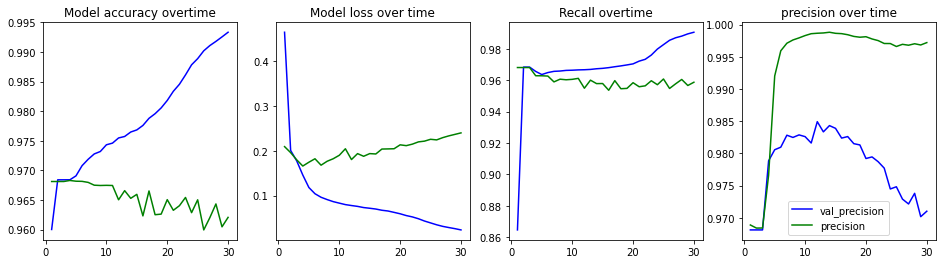

In [67]:
plot_history(history)